# Prophet, TBATS, SARIMAX модели для предсказания временных рядов

### 1. Задача
Рассмотрим датасет с kaggle соревнования по прогнозированию спроса на товары.


In [10]:
import pandas as pd

data = pd.read_csv('train.csv', parse_dates=['date'])
data.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


Как мы видим, датасет содержит информацию о магазинах, товарах и продажах. 
Выберем первый магазин и первый товар 
и будем предсказывать спрос на выбранный товар в данном магазине, 
используя последний год для сравнения моделей.

Выделим соотвествущие данные из датасета.

In [11]:
# Задаем магазин и продукт
store, item = 1, 1

# Выделяем только те данные, которые относятся к данному магазину и продукту 
data = data[(data['store'] == store) & (data['item'] == item)]

# Дату уставнавливаем как индекс
data = data.set_index('date')
                      
# Выделяем данные о продажах
data = data['sales']

### 2. Данные

Разделим данные на трейн и тест для обучения и тестирования результатов соотвественно. 
На тест отправляем данные за последний год.

In [12]:
test_size = 365
data_train = data.iloc[:-test_size]
data_test = data.iloc[-test_size:]

Визуализируем полученные данные. 
Визуализировать данные нужно с самого начала. 
Это помогает провалидировать данные и выделить некоторые закономерности.

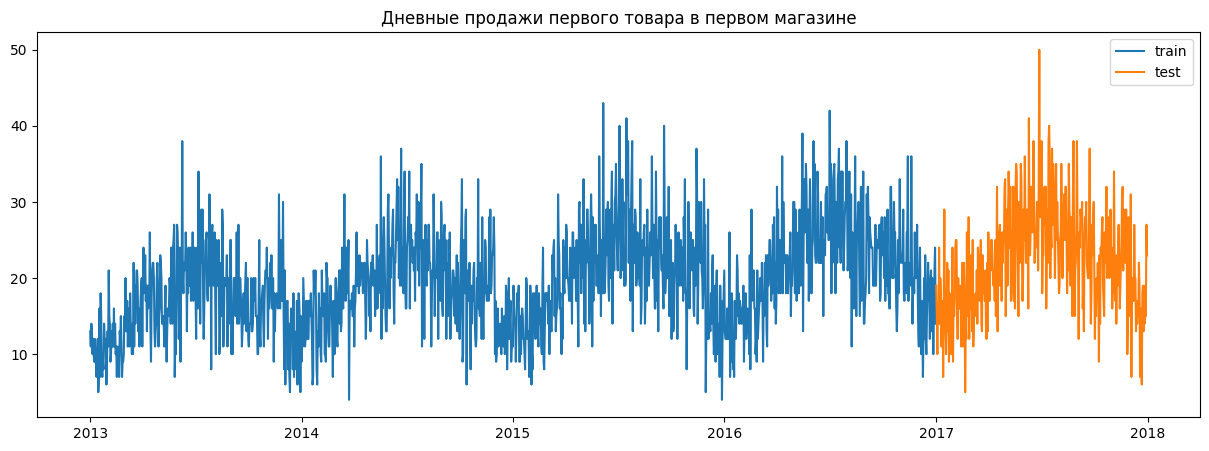

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.title('Дневные продажи первого товара в первом магазине')
plt.plot(data_train, label='train') 
plt.plot(data_test, label='test') 
plt.legend();

Видно, что данные обладают годичной сезонностью. 
Посмотрим теперь, есть ли недельная сезонность.

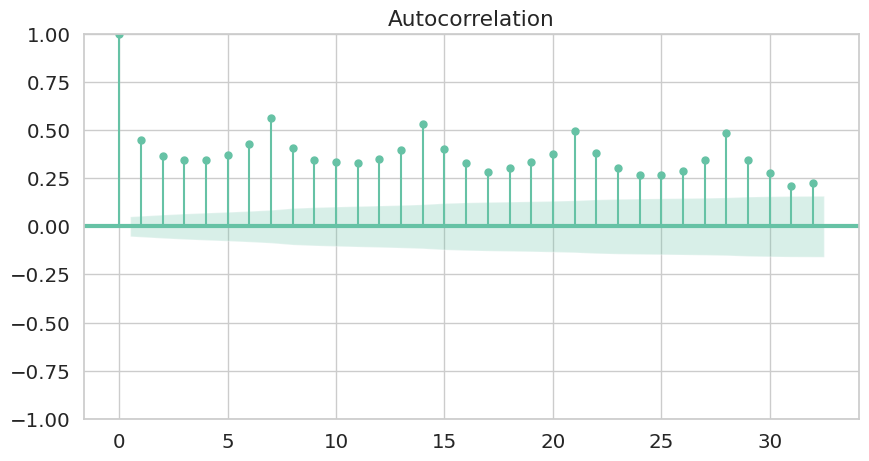

In [14]:
import seaborn as sns
sns.set(palette='Set2', font_scale=1.3)

import statsmodels
import statsmodels.api as sm
from statsmodels.stats.proportion import proportion_confint
from statsmodels.tsa.seasonal import seasonal_decompose, STL

from pylab import rcParams
# rcParams['figure.figsize'] = 15, 7

# отобразить график автокорреляционной функции 
# для анализа корреляций между временными данными и их лагами

rcParams["figure.figsize"] = 10, 5
with sns.axes_style('whitegrid'):
    statsmodels.graphics.tsaplots.plot_acf(data_train, lw=3)

Явная недельная сезонность

### 3. Метрики

Теперь веренмся к самой задаче.
Прежде чем ее решать, зададим метрики по которым мы будем определять,
какая из моделей лучше: MSE, MAE, MAPE. 
Напишем функцию, которая будет считать качество моеделей.

In [15]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
# from sklearn.metrics import mean_absolute_percentage_error

compare_table = None

def add_results_in_comparison_table(method: str, y_true, y_forecast) -> pd.DataFrame:
    """
    Добавляет новую строчку в таблицу compare_table с результатами текущей модели. 
    Если ранее модель была уже добавлена в таблицу, то старая строчка перезапишется 
    на новую. 
    
    Параметры:
    - method: имя модели.
    - y_true: истинные значения.
    - y_forecast: предсказанные значения.
    """
    # Обращаемся к глобальной переменной 
    global compare_table
    
    # Считаем метрики
    result_row = {
        "method": method,
        "MSE": mean_squared_error(y_true=y_true, y_pred=y_forecast),
        "MAE": mean_absolute_error(y_true=y_true, y_pred=y_forecast),
        "MAPE": mean_absolute_percentage_error(y_true=y_true, y_pred=y_forecast)
    }
    
    # Записываем результат в таблицу
    if compare_table is None:
        compare_table = pd.DataFrame([result_row]) 
    else:
        if method in list (compare_table['method']):
            compare_table = compare_table[compare_table("method") != method]
            
        compare_table = pd.concat([compare_table, pd. DataFrame([result_row])]) 
        compare_table.index = np.arange(len(compare_table))
    return compare_table

def mean_absolute_percentage_error(y_true, y_pred) -> float: 
    """Считает MAРE для y_true и y pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

### 4. Prophet

Prophet - модель разработанная Facebook для предсказания временных рядов.

`class fbprophet Prophet (growth='linear', 
changepoints-None, n_changepoints=25, changepoint range=0.8, 
yearly_seasonality="auto', weekly_seasonality='auto", daily_seasonality='auto', 
holidays=None, seasonality_mode='additive', seasonality_prior_scale=10.0, 
holidays_prior_scale=10.0, changepoint_prior_scale=0.05, mcmc_samples=0,
interval_width=0.8, uncertainty_samples=1000, stan_backend=None)`

Параметры:
* growth - (какой тренд) 'linear' или 'logistic';
* changepoints - точки изменения поведения временного ряда (тренда), которые пользователь задал cамостоятельно;
* n_changepoints - максимальное количество точек изменения поведения временного ряда;
* yearly_seasonality - годовая сезонность
* weekly_seasonality - недельна сезонность
* daily_seasonality - дневная сезонность
* holidays - pd.DataFrame с колонками holiday и ds (дата);
* seasonality_mode - 'additive' или 'multiplicative';
* interval_width - ширина доверительного интервала. **По умолчанию равна 0.8, а не 0.95**.

Для начала подготовим данные, чтобы их можно было передать модели.
Модель для обучения принимает на вход датасет из 2 колонок:
* da - дата
* y - временой ряд

In [16]:
prophet_train_df = pd.DataFrame(data_train) 
prophet_train_df.columns = ['y']
prophet_train_df['ds'] = prophet_train_df.index

Обучим модель:

In [ ]:
# pip install prophet

In [20]:
from prophet import Prophet

prophet_model = Prophet(interval_width=0.95)
prophet_model.fit(prophet_train_df)

08:52:15 - cmdstanpy - INFO - Chain [1] start processing
08:52:15 - cmdstanpy - INFO - Chain [1] done processing


Теперь посмотрим, как делать предсказания с Prophet.

У модели есть удобная функция make_future_dataframe, 
которая сама создает датасет сдатами на periods моментов вперед, 
а потом модель принимает этот датасет на вход для предсказания.

In [21]:
future = prophet_model.make_future_dataframe(
    periods=365, include_history=False
)
y_prophet_forecast = prophet_model.predict(future)

y_prophet_forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-01-01,22.666778,12.472511,29.495526,22.666778,22.666778,-1.504976,-1.504976,-1.504976,3.723746,3.723746,3.723746,-5.228722,-5.228722,-5.228722,0.0,0.0,0.0,21.161802
1,2017-01-02,22.670873,5.103585,21.439253,22.670873,22.670873,-9.437973,-9.437973,-9.437973,-4.232737,-4.232737,-4.232737,-5.205236,-5.205236,-5.205236,0.0,0.0,0.0,13.232900
2,2017-01-03,22.674967,6.704154,24.756598,22.674967,22.674971,-6.834796,-6.834796,-6.834796,-1.635941,-1.635941,-1.635941,-5.198855,-5.198855,-5.198855,0.0,0.0,0.0,15.840172
3,2017-01-04,22.679062,8.338568,24.590152,22.679050,22.679084,-6.322963,-6.322963,-6.322963,-1.114464,-1.114464,-1.114464,-5.208499,-5.208499,-5.208499,0.0,0.0,0.0,16.356099
4,2017-01-05,22.683157,8.573918,25.009094,22.683113,22.683212,-5.940420,-5.940420,-5.940420,-0.707802,-0.707802,-0.707802,-5.232617,-5.232617,-5.232617,0.0,0.0,0.0,16.742737


Модель для каждой даты раскладвыает свое предсказание на компоненты.


Из важного:
* `yhat` - предсказание модели. Предсказательный интервал: `[yhat_lower, yhat_upper]`.
* `trend` - значение тренда. Кроме того, модель умеет строить доверительный интервал для него: [trend_lover, trend_upper]
* `weekly` - значения сезонности по неделе. `[weekly_lower, weekly_upper]` - доверительный интервал. 
* `yearly` - значения сезонности по году. `[yearly_lower, yearly_upper]` - доверительный интервал.

Посмотрим теперь, как модель раскладывает временной ряд на компоненты:

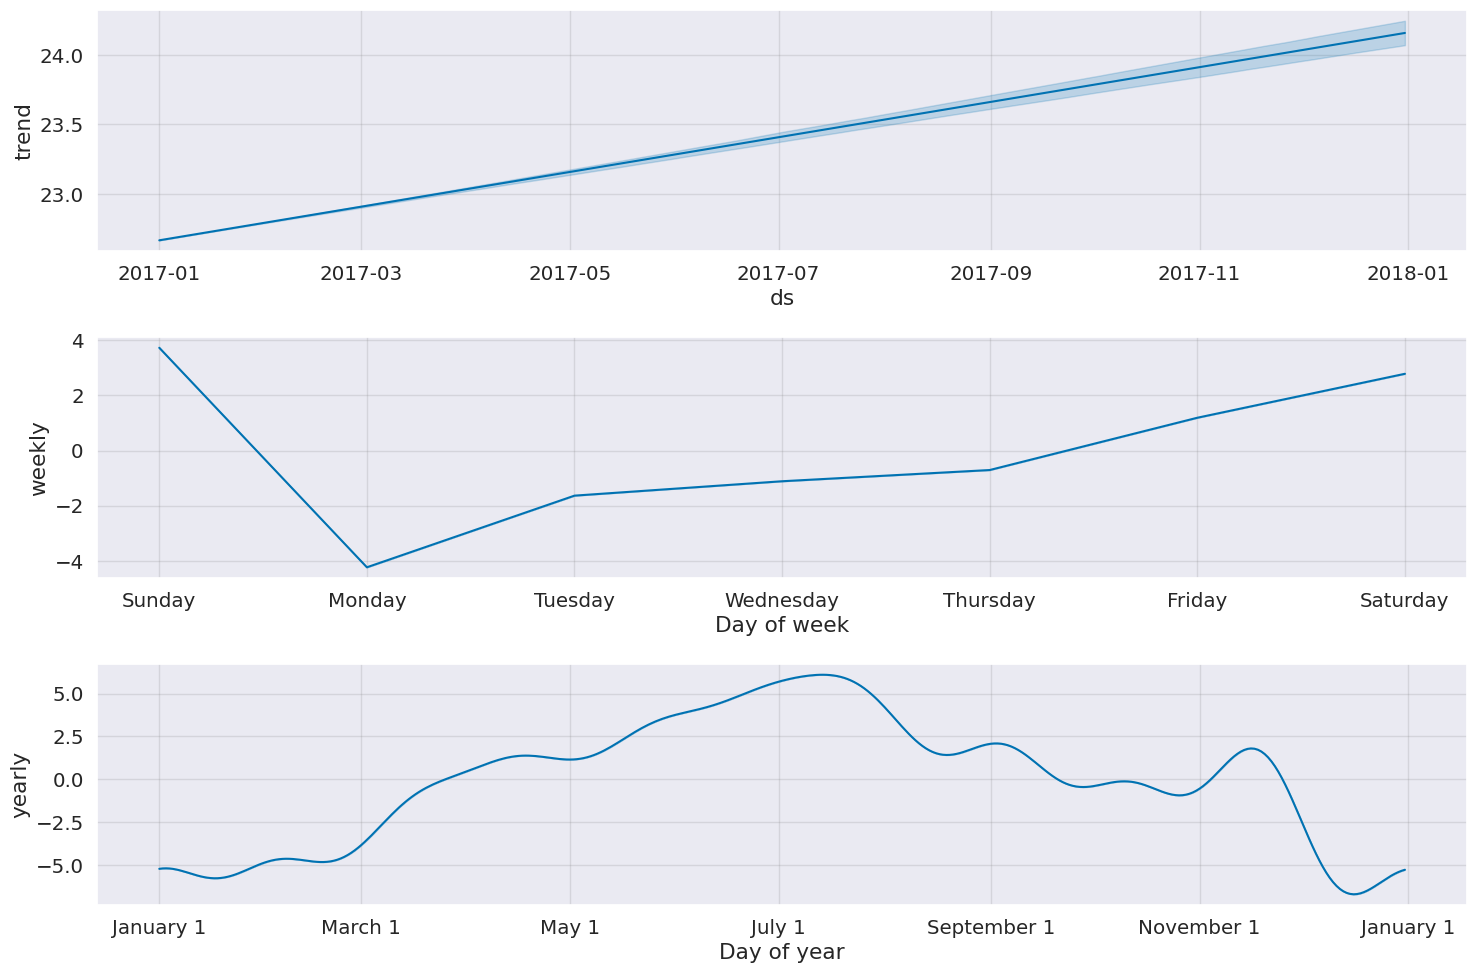

In [22]:
prophet_model.plot_components(y_prophet_forecast, figsize=(15, 10)) 
plt.show()

Отсюда можно делать выводы, что:
* тренд на товар положительный;
* меньше всего этот товар покупают в понедельник, больше всего - в выходные;
* летом товар пользуется наибольшим спросом, а зимой - наименьшим.


Отобразим полученные результаты.

In [23]:
def plot_results(y_to_train, y_to_test, y_forecast, plot_conf_int=True, 
                 left_bound=None, right_bound=None) :
    """
    Функция для визуализации временного ряда и предсказания.
    Параметры:
    - y_to_train: pd.Series
        Временной ряд, на котором обучалась модель.
    - y_to_test: pd.Series 
        Временной ряд, который предсказывает модель.
    - y forecast: array
        Предсказания модели.
    - plot_conf_int: bool 
        Надо ли строить предсказательный интервал.
    left bound: array 
        Левая граница предсказательного интервала.
    right bound: array
        Правая граница предсказательного интервала.
    """
    plt.figure(figsize=(15, 5))
    plt.title("Дневные продажи объекта 1 в магазине 1", fontsize=15)
    plt.plot(y_to_train, label='train')
    plt.plot(y_to_test, label='test') 
    plt.plot(y_to_test.index, y_forecast, label='prediction')
    if plot_conf_int:
        plt.fill_between(
            y_to_test.index,
            left_bound, 
            right_bound,
            alpha=0.3, 
            color='grey',
            label='conf.int'
        )
    plt.legend()
    plt.show()

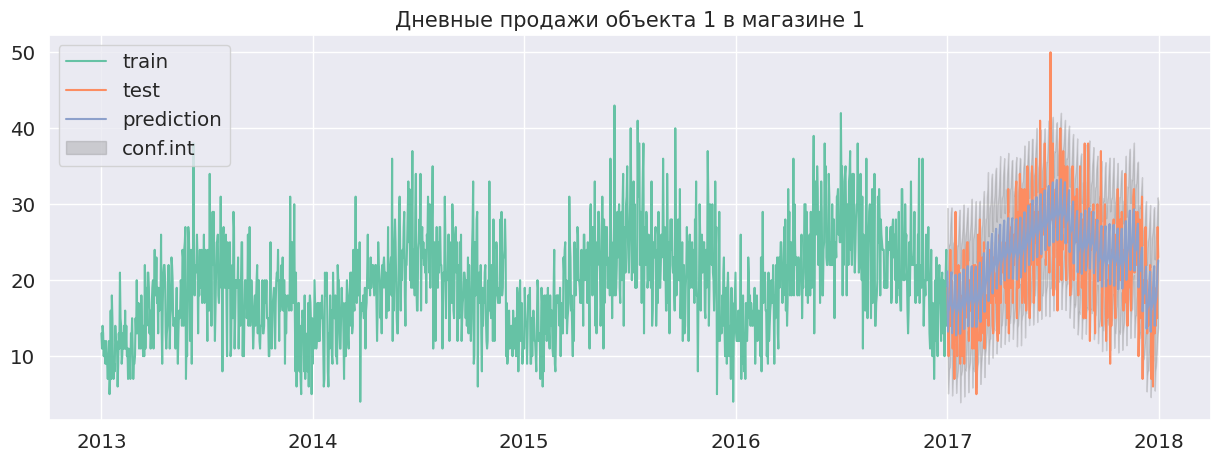

In [24]:
plot_results(data_train, data_test, y_prophet_forecast['yhat'], plot_conf_int=True, 
             left_bound=y_prophet_forecast['yhat_lower'],
             right_bound=y_prophet_forecast['yhat_upper'])

In [25]:
import numpy as np


add_results_in_comparison_table(method="Prophet", 
                                y_true=data_test, 
                                y_forecast=y_prophet_forecast['yhat'])

,method,MSE,MAE,MAPE
0,Prophet,24.728345,4.036651,22.275321


### Добавим в модель праздники и посмотрим на предсказаниия.

In [26]:
prophet_model_with_holidays = Prophet(interval_width=0.95)

In [27]:
# help(Prophet)
# print(dir(Prophet))

In [28]:
# 10 федеральных прездников США
prophet_model_with_holidays.add_country_holidays(country_name='US') 

prophet_model_with_holidays.fit(prophet_train_df)

08:52:17 - cmdstanpy - INFO - Chain [1] start processing
08:52:17 - cmdstanpy - INFO - Chain [1] done processing


In [29]:
prophet_model_with_holidays.train_holiday_names

0      Martin Luther King Jr. Day
1           Washington's Birthday
2                    Columbus Day
3                  New Year's Day
4                    Memorial Day
5                Independence Day
6                       Labor Day
7                    Veterans Day
8                    Thanksgiving
9                   Christmas Day
10       Christmas Day (Observed)
11    Independence Day (Observed)
dtype: object

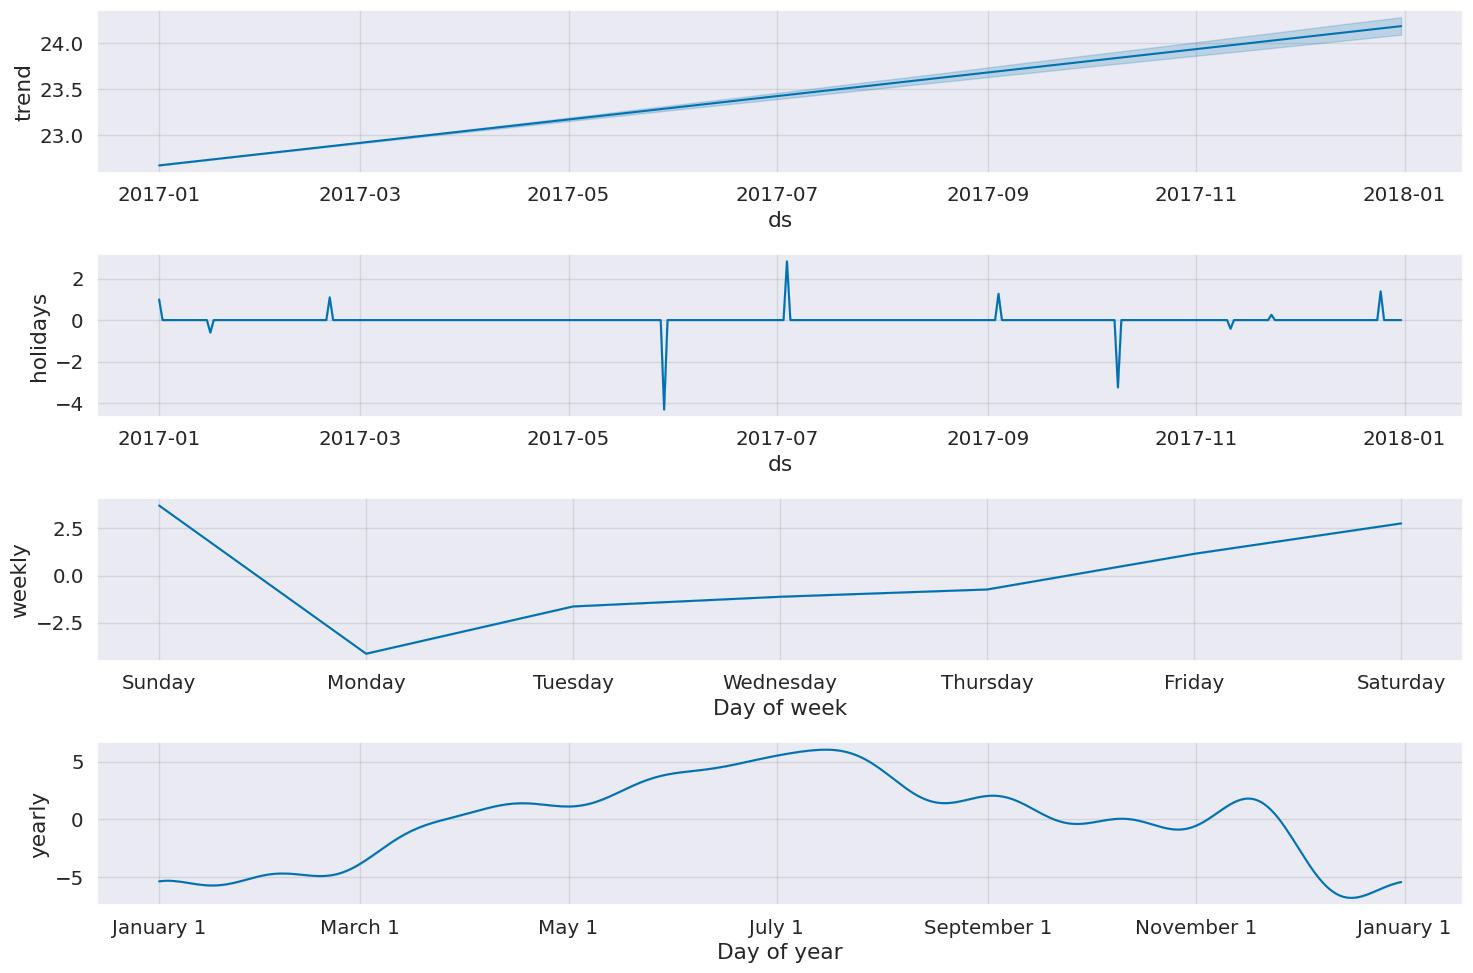

In [30]:
# Из графиков ниже мы можем заметить, 
# что товар реже покупали во время дня памяти и лучше во время дня независимости.

future = prophet_model_with_holidays.make_future_dataframe(
    periods=365, include_history=False
)
y_prophet_with_holidays_forecast = prophet_model_with_holidays.predict(future) 

prophet_model_with_holidays.plot_components(y_prophet_with_holidays_forecast, figsize=(15, 10)) 
plt.show()

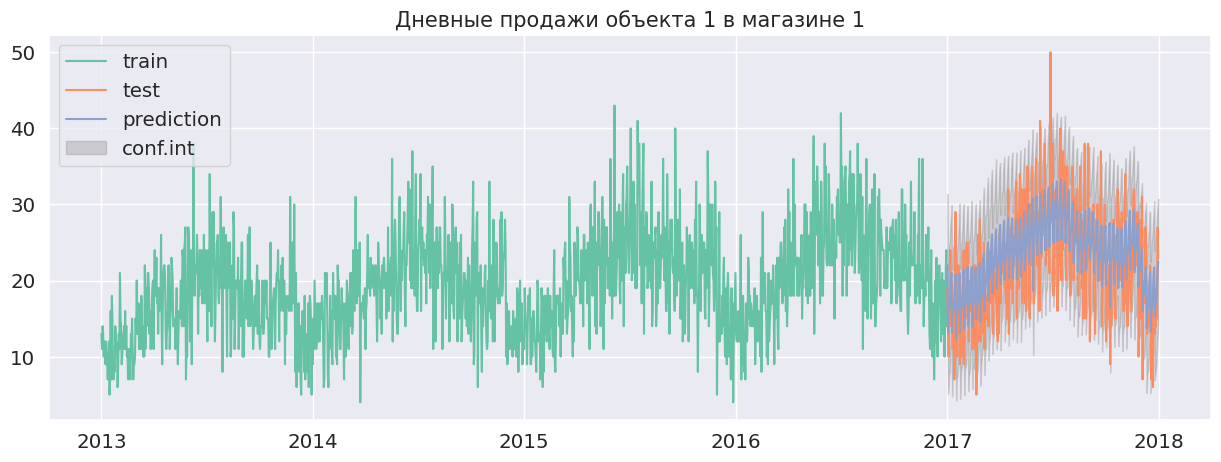

In [31]:
plot_results(
    data_train, 
    data_test, 
    y_prophet_with_holidays_forecast['yhat'], 
    plot_conf_int=True, 
    left_bound=y_prophet_with_holidays_forecast['yhat_lower'],
    right_bound=y_prophet_with_holidays_forecast['yhat_upper']
)

In [32]:
add_results_in_comparison_table(
    method="Prophet + holidays", 
    y_true=data_test, 
    y_forecast=y_prophet_with_holidays_forecast['yhat']
)

,method,MSE,MAE,MAPE
0,Prophet,24.728345,4.036651,22.275321
1,Prophet + holidays,24.973078,4.063423,22.436338


Добавление праздников не улучшило качество модели.


Правда ли, что предсказательный интервал у модели корректен и только $ 5% значений не попадают в интервал?

Давайте проверим какой процент от тестовых значений лежит вне доверительного интервала, то есть посчитаем процент ошибок.

Если 5% лежит в доверительном интервале на процент ошибок, значит предсказательный интервал у модели корректен.

In [33]:
def check_predictive_interval (y_to_test, left_bound, right_bound):
    """
    Функция проверяет, корректен ли предиктивный интервал.
    Если количество ошибок больше 5%, с помощью 
    доверительного интервала Уилсона считается, 
    лежит ли левая граница 95% доверительного интервала 
    для процента количества ошибок правее 54 или нет. 
    Если правее - значит предсказательный интервал неккоректен. 
    Иначе -- можно верить.
    """
    
    # ошибки        
    errors_number = ((np.array(y_to_test) < left_bound) | (np.array(y_to_test) > right_bound))
    
    # доверительный интервал на процент ошибок
    left, _ = proportion_confint(
        count=errors_number.sum(), 
        nobs=len(errors_number),
        alpha=0.05, 
        method='wilson')

    status = "OK" if left < 0.05 else 'ALERT'
    
    print(f"Pct. of errors: {round(np.mean(errors_number), 3)}, left bound: {round(left, 3)}, status: {status}")
    
check_predictive_interval(
    data_test,
    left_bound=y_prophet_forecast['yhat_lower'],
    right_bound=y_prophet_forecast['yhat_upper']
)

Pct. of errors: 0.082, left bound: 0.058, status: ALERT


Как видно, количество ошибок стат, значимо больше 5%, а значит не стоит доверять предсказательному интервалу Prophet.

### Теперь попробуем улучшить предсказания модели, применив изначально к ряду преобразования Бокса-Кокса.

С помощью sps.boxcох можно автоматически найти оптимальную $\lambda$ для преобразования и изменить автоматически ряд вместе с
ней.

In [35]:
from scipy import stats as sps

prophet_boxcox_train_df = prophet_train_df.copy()
prophet_boxcox_train_df['y'], lambda_prophet = sps.boxcox(prophet_boxcox_train_df['y'])

Отлично, осталось написать обратную функцию для трансформации Бокса-Кокса:

In [36]:
def invboxcox(y, lmbda):
    """Обратное преобразование Бокса-Кокса"""
    if lmbda == 0:
        return(np.exp(y))
    else:
        return (np.exp(np.log (lmbda * y + 1) / lmbda))

Теперь обучим новую модель на преобразованных данных:

In [37]:
# print(dir(Prophet))

In [38]:
prophet_boxcox_model = Prophet(interval_width=0.95) 
prophet_boxcox_model.fit(prophet_boxcox_train_df)

future_boxcox = prophet_boxcox_model.make_future_dataframe(periods=365, include_history=False) 
y_prophet_boxcox_forecast = prophet_boxcox_model.predict(future_boxcox)

y_prophet_boxcox_forecast['yhat'] = invboxcox(y_prophet_boxcox_forecast.yhat, lambda_prophet) 
y_prophet_boxcox_forecast['yhat_lower'] = invboxcox(y_prophet_boxcox_forecast.yhat_lower, lambda_prophet) 
y_prophet_boxcox_forecast['yhat_upper'] = invboxcox(y_prophet_boxcox_forecast.yhat_upper, lambda_prophet)

08:52:19 - cmdstanpy - INFO - Chain [1] start processing
08:52:19 - cmdstanpy - INFO - Chain [1] done processing


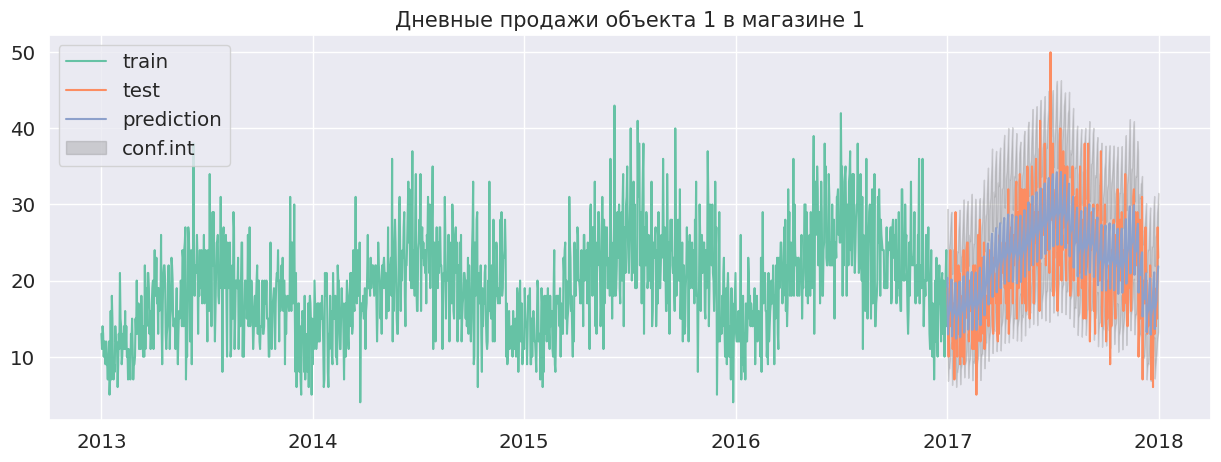

In [39]:
prophet_boxcox_prediction = y_prophet_boxcox_forecast['yhat']
plot_results(
    data_train, 
    data_test, 
    prophet_boxcox_prediction, 
    plot_conf_int=True, 
    left_bound=y_prophet_boxcox_forecast["yhat_lower"], 
    right_bound=y_prophet_boxcox_forecast['yhat_upper']
)

In [40]:
add_results_in_comparison_table(
    'Prophet + boxcox', 
    data_test, 
    prophet_boxcox_prediction
)

,method,MSE,MAE,MAPE
0,Prophet,24.728345,4.036651,22.275321
1,Prophet + holidays,24.973078,4.063423,22.436338
2,Prophet + boxcox,24.095305,3.985840,21.665325


Видим, что результаты стали лучше.

Проверим теперь предсказательный интервал:

In [41]:
check_predictive_interval(
    data_test,
    left_bound=y_prophet_boxcox_forecast['yhat_lower'],
    right_bound=y_prophet_boxcox_forecast['yhat_upper']
)

Pct. of errors: 0.071, left bound: 0.049, status: OK


## 5. Auto Arima

Посмотрим, как будет предсказывать модель, полученная через auto_arima.
Для начала обучим модель.

In [42]:
from pmdarima import auto_arima

arima_model = auto_arima(
    data_train, 
    seasonal=True, # есть сезонность
    m=7 # сезнонност недельная
)

Получим предсказания:

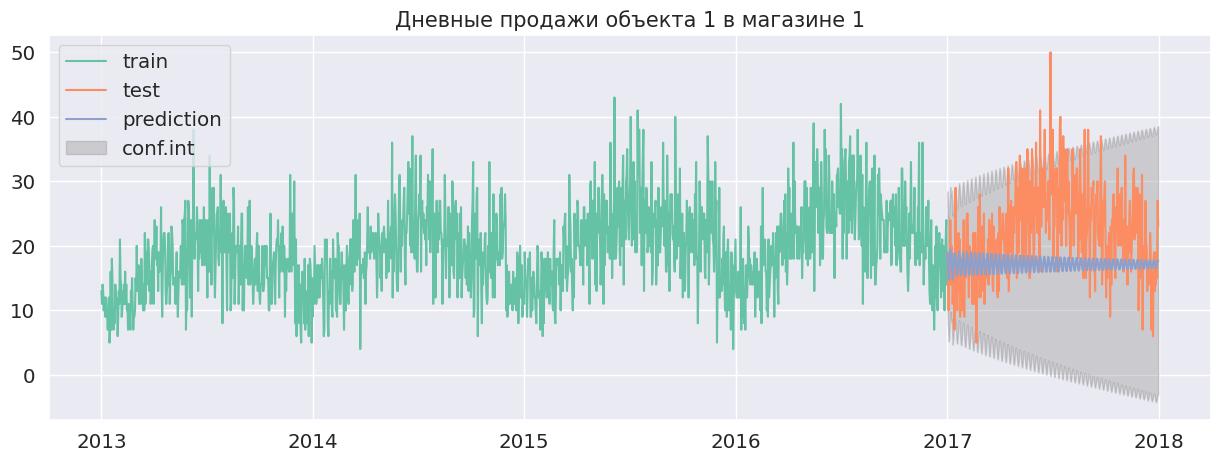

In [43]:
y_arima_forecast, conf_int = arima_model.predict( 
    n_periods=365, 
    return_conf_int=True, 
    alpha=0.05
)

plot_results(
    data_train, 
    data_test, 
    y_arima_forecast, 
    plot_conf_int=True,
    left_bound=conf_int.T[0],
    right_bound=conf_int.T[1]
)

Как видно, модель не выучила годовую сезонность, что логично, так как она о ней ничего не знала. 
Использовать же в качестве периода 365 дней плоха идея, потому что:
* будет очень долго обучаться с очень большими вычислениями;
* может легко привести к переобучению, так как модель будет смотреть на большое число значений назад.

Посмотрим теперь на качество:

In [44]:
add_results_in_comparison_table(
    'Auto Arima model', 
    data_test, 
    y_arima_forecast
)

,method,MSE,MAE,MAPE
0,Prophet,24.728345,4.036651,22.275321
1,Prophet + holidays,24.973078,4.063423,22.436338
2,Prophet + boxcox,24.095305,3.985840,21.665325
3,Auto Arima model,70.980460,6.649269,28.917656


Качество наихудшее среди всех моделей.

Посмотрим теперь, насколько хорош предсказательный интервал:

In [45]:
check_predictive_interval(
    data_test,
    left_bound=conf_int.T[0],
    right_bound=conf_int.T[1]
)

Pct. of errors: 0.066, left bound: 0.045, status: OK


Видно, что предсказательный интервал прошел сейчас по границе.

### Теперь попробуем учесть годовую сезонность через экзогенные признаки, а точнее через ряды Фурье.

Будем рассматривать разложение в ряд Фурье до `К = 2` первых слагаемых. 

На практике `К` надо также перебирать, как и `p, d, q, P, D, Q` в `SARIMAX`, оптимизируя один из информационнных критериев.

In [49]:
exog = pd.DataFrame({'date': data.index}) 

exog = exog.set_index(pd.PeriodIndex(exog['date'], freq='D'))

# первые слагаемые в ряде Фурье 
exog['sin365'] = np.sin(2 * np.pi * exog.index.dayofyear / 365.25) 
exog['cos365'] = np.cos(2 * np.pi * exog.index.dayofyear / 365.25)

# вторые слагаемые в ряде Фурье, поэтому вместо 2pi -> 4pi   
exog['sin365_2'] = np.sin(4 * np.pi * exog.index.dayofyear / 365.25) 
exog['cos365 2'] = np.cos(4 * np.pi * exog.index.dayofyear / 365.25) 

exog = exog.drop(columns=['date'])
     
exog_to_train = exog.iloc[:-365] 
exog_to_test = exog.iloc[-365:]

Причем период сезонности равнен 365.25, так как через каждые 4 года в году 366 дней.

Обучим новую Auto Arima модель, используя эти экзогенные признаки:

In [53]:
arima_exog_model = auto_arima(
    y=data_train, 
    exogenous=exog_to_train, 
    seasonal=True, 
    m=7
) 

y_arima_exog_forecast, conf_int_exog = arima_exog_model.predict(
    n_periods=365,
    exogenous=exog_to_test,
    return_conf_int=True,
    alpha=0.05
)

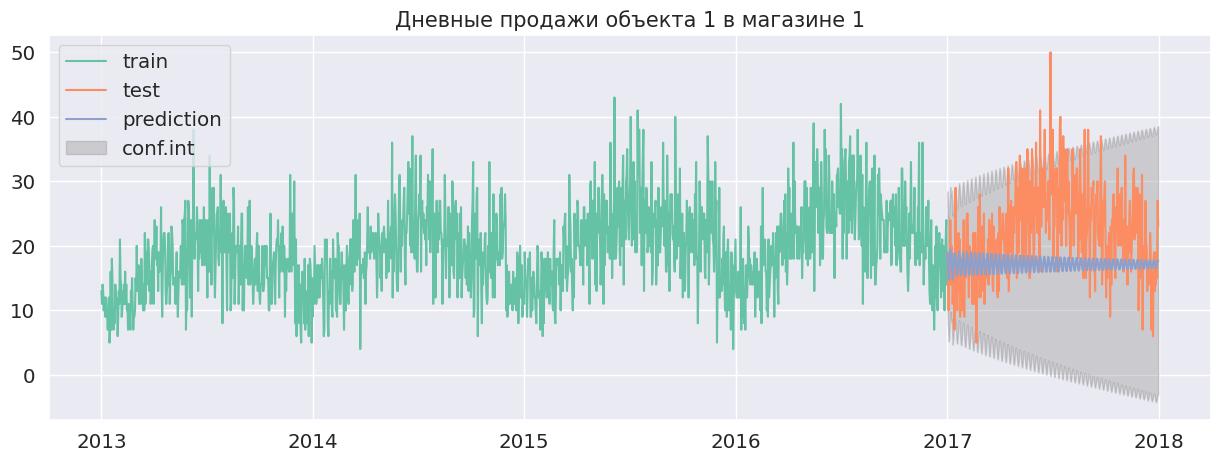

In [54]:
# Полученные предсказания

plot_results(
    data_train, 
    data_test, 
    y_arima_exog_forecast, 
    plot_conf_int=True, 
    left_bound=conf_int_exog.T[0],
    right_bound=conf_int_exog.T[1]
)

In [55]:
add_results_in_comparison_table(
    'Auto Arima model with Fourier exog', 
    data_test, 
    y_arima_exog_forecast
)

,method,MSE,MAE,MAPE
0,Prophet,24.728345,4.036651,22.275321
1,Prophet + holidays,24.973078,4.063423,22.436338
2,Prophet + boxcox,24.095305,3.985840,21.665325
3,Auto Arima model,70.980460,6.649269,28.917656
4,Auto Arima model with Fourier exog,70.980460,6.649269,28.917656


Видно, что качество модели сильно возросло по сравнению с обычной ARIMA моделью, но все еще хуже чем остальные методы.


In [56]:
check_predictive_interval(
    data_test,
    left_bound=conf_int_exog.T[0],
    right_bound=conf_int_exog.T[1]
)

Pct. of errors: 0.066, left bound: 0.045, status: OK


Зато предсказательный интервал в этот раз точно корректен.

## 6. TBATS
Теперь посмотрим на модель, которая была специально построена, чтобы учитывать несколько сезонностей.

`class tbatsTBATS (use_box_cox=None, box_cox_bounds=(0, 1), use_trend=None, use_damped_trend None, seasonal_periods-None, use_arma_errors-True, show_warnings-True, n_jobs-None, multiprocessing_start_method='spawn',
context None)`

Параметры:
* `use_box_соx` -использовать или нет преобразование Бокса-Кокса;
* `box_сox_bounds` -минимальное и макисимальное значение в преобразовании;
* `use_trend` -использовать или нет тренд;
* `use_damped_trend` -должен ли тренд уменьшаться со временем или нет;
* `seasonal_periods` -список с периодами сезонности;
* `n_jobs` -количество ядер.

Все параметры None подбираются автоматически, оптимизируя информационный критерий AIC.

**Недостаток модели:**

Она не может использовать никакие внешние факторы, к примеру, информацию о праздниках.

In [58]:
# Передадим модели недельную и годовую сезонность и обучим ее.

from tbats.tbats import TBATS 

tbats_estimator = TBATS(seasonal_periods=(7, 365.25), n_jobs=20) 
model = tbats_estimator.fit(data_train)

In [59]:
# Посмотрим на параметры оптимальной модели

print(model.summary())

Use Box-Cox: True
Use trend: False
Use damped trend: False
Seasonal periods: [  7.   365.25]
Seasonal harmonics [ 3 11]
ARMA errors (p, q): (0, 0)
Box-Cox Lambda 0.235062
Smoothing (Alpha): 0.015744
Seasonal Parameters (Gamma): [ 8.38113532e-04  1.66471021e-03 -1.79424268e-03  2.73930434e-06]
AR coefficients []
MA coefficients []
Seed vector [ 3.81375012e+00 -2.74641307e-01 -1.69626433e-02  1.26130142e-01
 -5.67940137e-02  1.86127376e-01  1.01121445e-01 -5.00467180e-01
 -5.29878240e-02 -1.14033015e-01 -5.71844326e-03 -4.67507534e-02
  2.10869447e-05  3.17364188e-02  2.56748949e-02  4.95180714e-02
  3.09193502e-02  3.19082554e-02 -6.20529076e-02 -1.00281494e-01
 -7.52734763e-02  2.34409118e-02  6.82538555e-02  7.30943945e-02
  9.59125820e-03  1.53375666e-02 -1.72073113e-02 -3.43624772e-02
 -4.08392867e-03]

AIC 14975.138513


Видно, что
* ARMA коэффициенты равны 0;
* тренда модель не нашла;
* модель посчитала важным использовать преобразование Бокса-Кокса.

Теперь построим предсказания на год вперед.

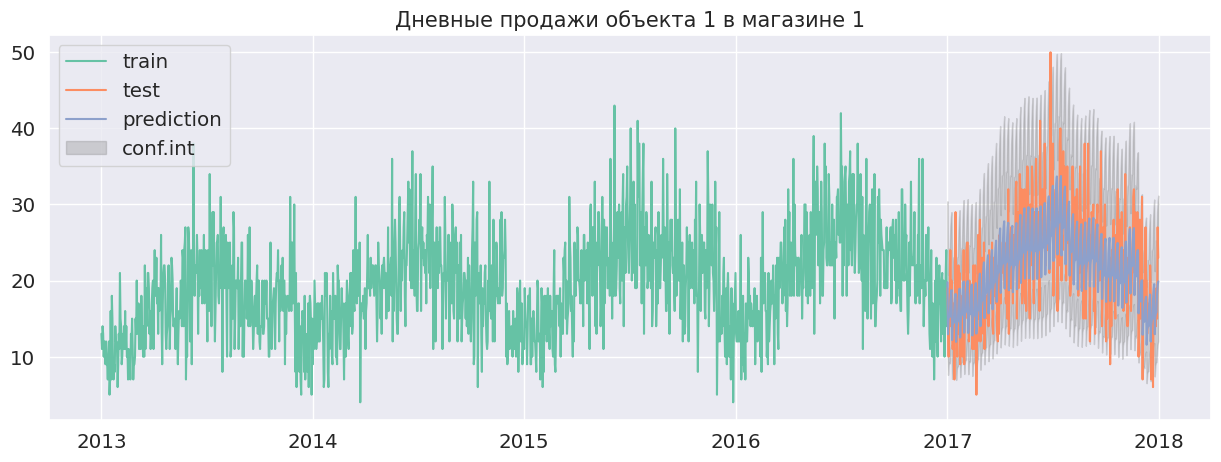

In [61]:
tbats_forecast, confidence_info = model.forecast (steps=365, confidence_level=0.95)

plot_results(
    data_train, 
    data_test, 
    tbats_forecast, 
    plot_conf_int=True,
    left_bound=confidence_info['lower_bound'],
    right_bound=confidence_info['upper_bound']
)

In [62]:
# Посмотрим на результаты сравнения по метрике:

add_results_in_comparison_table('TBATS model', data_test, tbats_forecast)

,method,MSE,MAE,MAPE
0,Prophet,24.728345,4.036651,22.275321
1,Prophet + holidays,24.973078,4.063423,22.436338
2,Prophet + boxcox,24.095305,3.985840,21.665325
3,Auto Arima model,70.980460,6.649269,28.917656
4,Auto Arima model with Fourier exog,70.980460,6.649269,28.917656
5,TBATS model,23.639728,3.859337,19.795331


In [63]:
# TBATS побил все предыдущие модели по качеству по всем 3 метрикам.

# Посмотрим теперь на предсказательный интервал:

check_predictive_interval(
    data_test,
    left_bound=confidence_info['lower_bound'],
    right_bound=confidence_info['upper_bound']
)

Pct. of errors: 0.047, left bound: 0.029, status: OK


Видно, что процент ошибок примерно 5%, а значит предсказательный интервал у модели корректен.

## Итого

В данном нотубуке было рассмотрено, как работать со следующими моделями:
* Prophet;
* auto arima с экзогенными факторами для учета нескольких сезонностей;
* TBATS модель.

На данном датасете лучше всего себя показала TBATS модель, но в других случаях, когда есть экзогенные факторы, остальные
модели могут получить качество лучше.

https://miptstats.github.io/

In [ ]:
# from dateutil.parser import parse
# from tqdm.auto import tqdm

# from sklearn.preprocessing import StandardScaler

# from gplearn.genetic import SymbolicRegressor
# from tbats import TBATS, BATS

# from pmdarima import auto_arima